## Proyecto Hurst - Notebook 2

# Analisis del exponente de Hurst sobre los valores del SP500


En este notebook veremos el uso de Python para descargar el histórico de cotización diaria de valores del SP500.

Sobre estos datos realizaremos un calculo complejo como es el exponente de Hurst y en base a los resultados seleccionaremos una muestra de activos con series temporales persistentes o tendenciales.

---

## Obtención de las cotizaciones históricas de los valores del SP500

Para comenzar vamos a obtener la lista de los ticker de los valores del SP500. Para ello usaremos el modulo de Python **finsymbols**, que importaremos en primer lugar.

In [1]:
import finsymbols

Con este modulo podemos obtener los datos de los valores que componen el SP500.

In [2]:
sp500 = finsymbols.symbols.get_sp500_symbols()
print ('Número de valores : {}'.format(len(sp500))) #comprobamos su longitud, el número de valores.

Número de valores : 505


Veamos los cinco primeros valores.

In [3]:
sp500[:5]

[{'company': '3M Company',
  'headquarters': 'St. Paul, Minnesota',
  'industry': 'Industrial Conglomerates',
  'sector': 'Industrials',
  'symbol': 'MMM'},
 {'company': 'Abbott Laboratories',
  'headquarters': 'North Chicago, Illinois',
  'industry': 'Health Care Equipment',
  'sector': 'Health Care',
  'symbol': 'ABT'},
 {'company': 'AbbVie Inc.',
  'headquarters': 'North Chicago, Illinois',
  'industry': 'Pharmaceuticals',
  'sector': 'Health Care',
  'symbol': 'ABBV'},
 {'company': 'ABIOMED Inc',
  'headquarters': 'Danvers, Massachusetts',
  'industry': 'Health Care Equipment',
  'sector': 'Health Care',
  'symbol': 'ABMD'},
 {'company': 'Accenture plc',
  'headquarters': 'Dublin, Ireland',
  'industry': 'IT Consulting & Other Services',
  'sector': 'Information Technology',
  'symbol': 'ACN'}]

Para descargar sus históricos diarios necesitamos solamentes sus simbolos, así que creamos una lista de los simbolos de los valoeres. 
Para comprobar listamos los 5 primeros.

In [4]:
valores_sp=[str(sp500[a]['symbol']) for a in range(len(sp500))]
valores_sp[:5]

['MMM', 'ABT', 'ABBV', 'ABMD', 'ACN']

Importamos el módulo **fix_yahoo_finance**, que nos permitirá descargar gratuítamente las cotizaciones desde los servidores de Yahoo Finance.

Utilizamos este modulo para descargar nuestra lista de valores pasando las fechas del intervalo que queremos descargar.
La descargará tomará su tiempo ya que son mas de 500 en un periodo muy largo y se hace mediante un scrap de la web de Yahoo Finanzas (antes de que Yahoo decidiera descontinuar su API era mas rapido).

In [5]:
import fix_yahoo_finance as yf

In [6]:
data = yf.download(valores_sp, start="2004-01-01", end="2018-06-13")
data.shape # Comprobamos las dimensiones del panel donde hemos almacenado las cotizaciones.

[*********************100%***********************]  505 of 505 downloaded


(6, 3637, 505)

Echemos un vistazo a un valor para comprobar como se ven los datos.

In [7]:
data.minor_xs('MMM').head(5) # El simbolo corresponde a 3M como hemos visto antes, visualizamos los 5 primeros días.

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2003-12-31,59.341152,85.029999,85.080002,84.400002,84.480003,1626300.0
2004-01-02,58.182701,83.370003,85.190002,83.110001,85.000000,2591700.0
2004-01-05,59.292332,84.959999,85.000000,83.320000,83.580002,2985200.0
2004-01-06,59.110878,84.699997,84.959999,84.400002,84.500000,2983100.0
2004-01-07,58.091946,83.239998,84.250000,82.699997,84.120003,4293600.0


In [8]:
data.minor_xs('MMM').tail(5) # y los últimos 5 días.

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2018-06-06,203.860001,203.860001,204.050003,201.550003,201.839996,2297300.0
2018-06-07,205.070007,205.070007,205.889999,203.759995,204.179993,2279200.0
2018-06-08,206.589996,206.589996,206.750000,204.410004,204.979996,2170200.0
2018-06-11,205.119995,205.119995,206.789993,205.000000,206.589996,2302900.0
2018-06-12,204.919998,204.919998,205.949997,203.949997,205.669998,1806100.0


---

## Calculo del Exponente de Hurst

Para esta tarea necesitamos importar el módulo **numpy** que tiene potentes herramientas de cálculo matemático.

In [9]:
from numpy import *

Para calcular el exponente de Hurst vamos a definir una función que luego aplicaremos a todos los valores.

Los parametros de esta función seran las series temporales de cotizaciones diarias, pero podríamos utilizarla con cualquier tipo de serie temporal.

El exponente de Hurst tiene un calculo complejo, en nuestro caso usamos un ajuste mediante la función polyfit para aproximarlo. Esta basado en el creado por Ernest Chan para Mathlab, y es una versión del publicado en Quantopian para Python.

Usamos los parametros del rango de las demoras que determine en el notebook anterior sobre el estudio del exponente de Hurst con datos sinteticos, en dicho estudio comprobamos que para que tenga cierta valided debemos usar muestras no menores de 2.000 valores, y preferiblemente entre 3.000 y 5.000 valores.

In [10]:
import warnings; warnings.simplefilter('ignore') # Importamos el modulo warnings y desactivamos los avisos para evitar flood

def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Creamos el rango de los valores de demora
    lags = range(10, 500)

    # Calculamos la matriz de varianzas de las diferencias de las demoras
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Usamos un ajuste lineal para estimar el exponente de Hurst
    poly = polyfit(log(lags), log(tau), 1)

    # Devolvemos el exponente de Hurst obtenido del ajuste lineal
    return poly[0]*2.0

Calculamos el exponente de Hurst sobre el histórico del precio de cierre ajustado de cada valor.

In [11]:
Hurst=[hurst(data['Adj Close'][asset].dropna()) for asset in data.minor_axis]

Importamos el genial modulo Pandas para gestión de dataframes que nos facilitará el manejo de datos.

In [12]:
import pandas as pd

Creamos un dataframe que recoja los datos de las acciones que descargamos con finsymbols y le añadimos el exponente de Hurst calculado y el numero de datos diarios que tiene ese valor.

In [13]:

df_hurst=pd.DataFrame(sp500).sort_values('symbol')

df_hurst['Hurst']=Hurst
df_hurst['Num datos']=[data['Adj Close'][asset].count() for asset in list(data.minor_axis)]

df_hurst.head(5) # visualizamos los 5 primeros valores

,company,headquarters,industry,sector,symbol,Hurst,Num datos
14,Agilent Technologies Inc,"Santa Clara, California",Health Care Equipment,Health Care,A,0.467296,3637
32,American Airlines Group,"Fort Worth, Texas",Airlines,Industrials,AAL,0.551244,3199
9,Advance Auto Parts,"Roanoke, Virginia",Automotive Retail,Consumer Discretionary,AAP,0.454438,3637
52,Apple Inc.,"Cupertino, California","Technology Hardware, Storage & Peripherals",Information Technology,AAPL,0.524185,3637
2,AbbVie Inc.,"North Chicago, Illinois",Pharmaceuticals,Health Care,ABBV,0.366496,1371


No vamos a utilizar en este notebook mas los históricos diarios, pero por si nos son utiles para otro estudio, los guardamos en un archivo, así evitamos tener que descargarlos de nuevo.

In [14]:
data. to_pickle('Valores de SP500 - cotizacion diaria.pk1')


---

# Visualización gráfica de los datos obtenidos

Importamos el modulo matplotlib y lo habilitamos para que se visalice en linea dentro del notebook.

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 26, 12 # Ajustamos el tamaño de los gráficos para que se ajusten mejor al notebook.

Generamos un grafico de barras con el exponente de Hurst de los 30 primeros valores, añadiendo el valor numérico y una linea de corte en el valor 0,50.

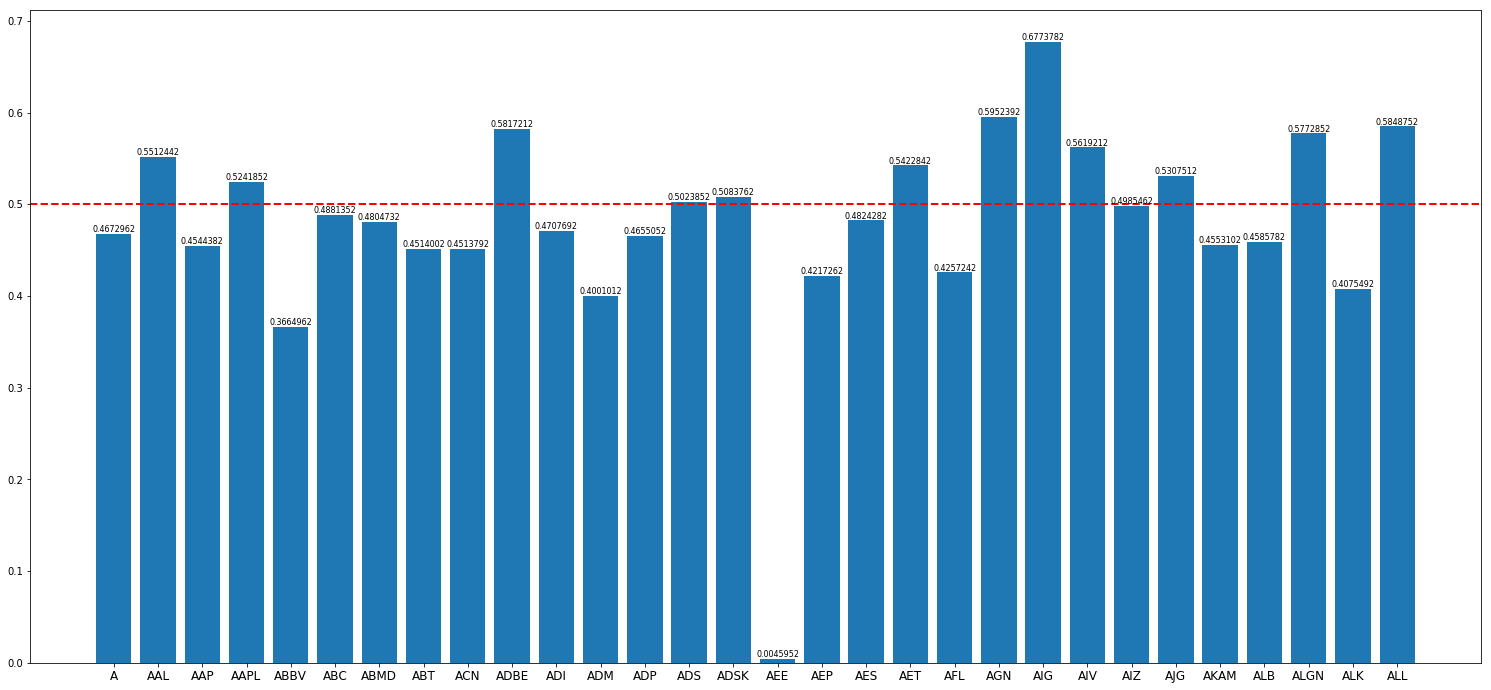

In [18]:
num=30 #seleccionamos las 30 primeras

y_pos = arange(num)

fig, ax = plt.subplots() 
bars=ax.bar(y_pos, df_hurst.Hurst[:num])
ax.set_xticks(y_pos)

xlabels=ax.set_xticklabels(df_hurst.symbol[:num], size=num, fontdict={'fontsize':12})

ax.axhline(0.5,  color='r', linestyle='dashed', linewidth=2)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., 1.0*height,
            '%f2' % height,
            ha='center', va='bottom', color='k', size=8)

Como algunos valores comenzarón a cotizar posteriormente a la fecha que hemos definido como inicio, tienen menos barras diarias. Vamos a desestimar esos valores para el analisis por no ser homogeneo su calculo. El resto los ordenamos descendentemente según el valor de Hurst.

In [20]:
muestra=df_hurst[df_hurst['Num datos']==3637].sort_values(by='Hurst', ascending=False)
muestra[:10] # visualizamos las 10 primeras

,company,headquarters,industry,sector,symbol,Hurst,Num datos
162,DXC Technology,"Tysons Corner, Virginia",IT Consulting & Other Services,Information Technology,DXC,0.711385,3637
116,Citigroup Inc.,"New York, New York",Diversified Banks,Financials,C,0.699077,3637
351,Nvidia Corporation,"Santa Clara, California",Semiconductors,Information Technology,NVDA,0.693917,3637
35,"American International Group, Inc.","New York, New York",Property & Casualty Insurance,Financials,AIG,0.677378,3637
163,E*Trade,"New York, New York",Investment Banking & Brokerage,Financials,ETFC,0.669651,3637
131,Constellation Brands,"Victor, New York",Distillers & Vintners,Consumer Staples,STZ,0.664789,3637
462,United Health Group Inc.,"Minnetonka, Minnesota",Managed Health Care,Health Care,UNH,0.649895,3637
274,KeyCorp,"Cleveland, Ohio",Regional Banks,Financials,KEY,0.649024,3637
398,Regions Financial Corp.,"Birmingham, Alabama",Regional Banks,Financials,RF,0.647790,3637
313,MGM Resorts International,"Paradise, Nevada",Casinos & Gaming,Consumer Discretionary,MGM,0.639052,3637


Para ver como se distribuye la muestra de valores que hemos tomado, generamos un histiograma.

Marcamos los valores de corte 0,45 y 0,55.  Los que se encuentran entre esos valores podemos considerar su cotización sigue un movimiento browniano.

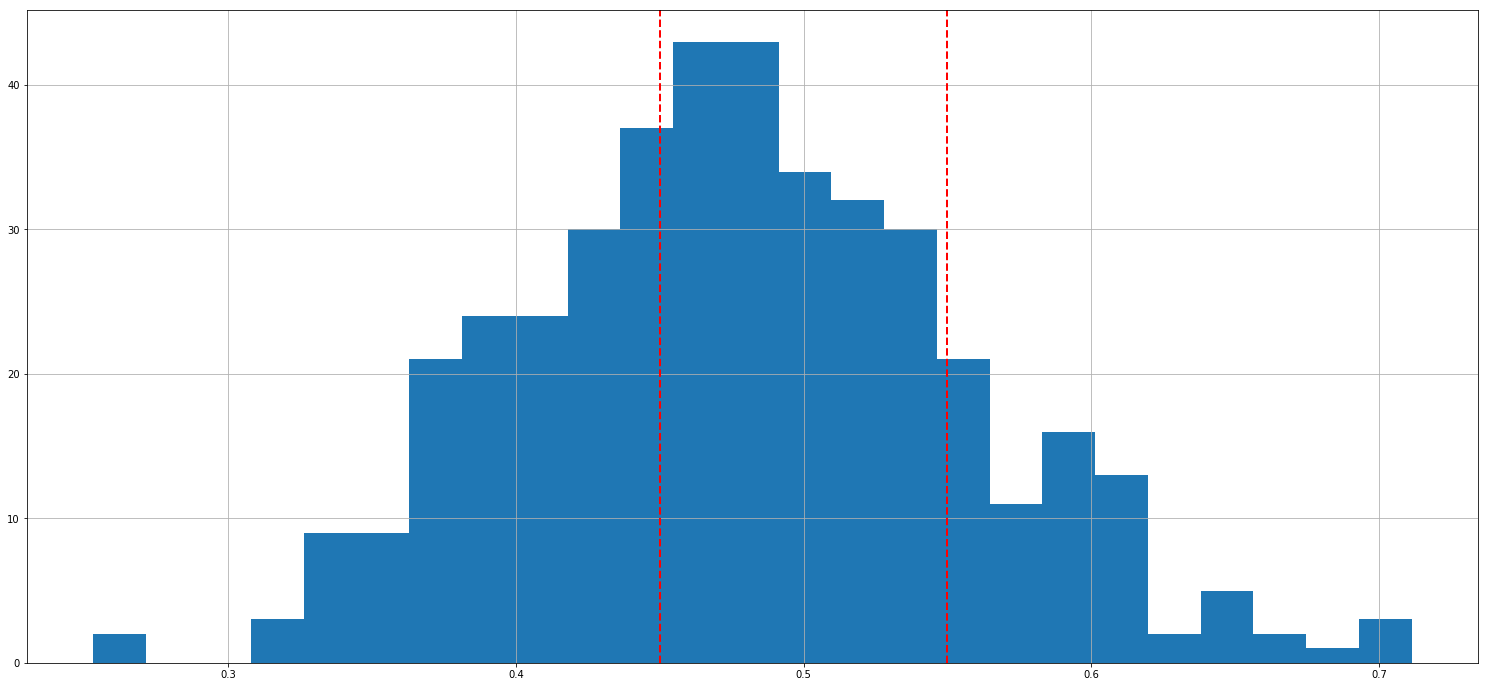

In [21]:
muestra.Hurst.hist(bins=25)
plt.axvline(0.55,  color='r', linestyle='dashed', linewidth=2)
plt.axvline(0.45,  color='r', linestyle='dashed', linewidth=2)

Veamos el analisis de los valores agrupados por Industria.

In [22]:
industrias=muestra.groupby('industry')['Hurst'].mean() # calculamos la media de los valores de Hurst

In [23]:
industrias.sort_values(ascending=False)[:12] # vusualizamos los 12 primeros

industry
Distillers & Vintners                  0.664789
Diversified Support Services           0.636793
Casinos & Gaming                       0.612739
Food Retail                            0.575678
Home Entertainment Software            0.572328
Environmental & Facilities Services    0.563828
Property & Casualty Insurance          0.558602
Aerospace & Defense                    0.557413
Semiconductor Equipment                0.557152
Financial Exchanges & Data             0.555994
Regional Banks                         0.554927
Auto Parts & Equipment                 0.542854
Name: Hurst, dtype: float64

Veamos la media por industria del exponente de Hurst de forma gráfica

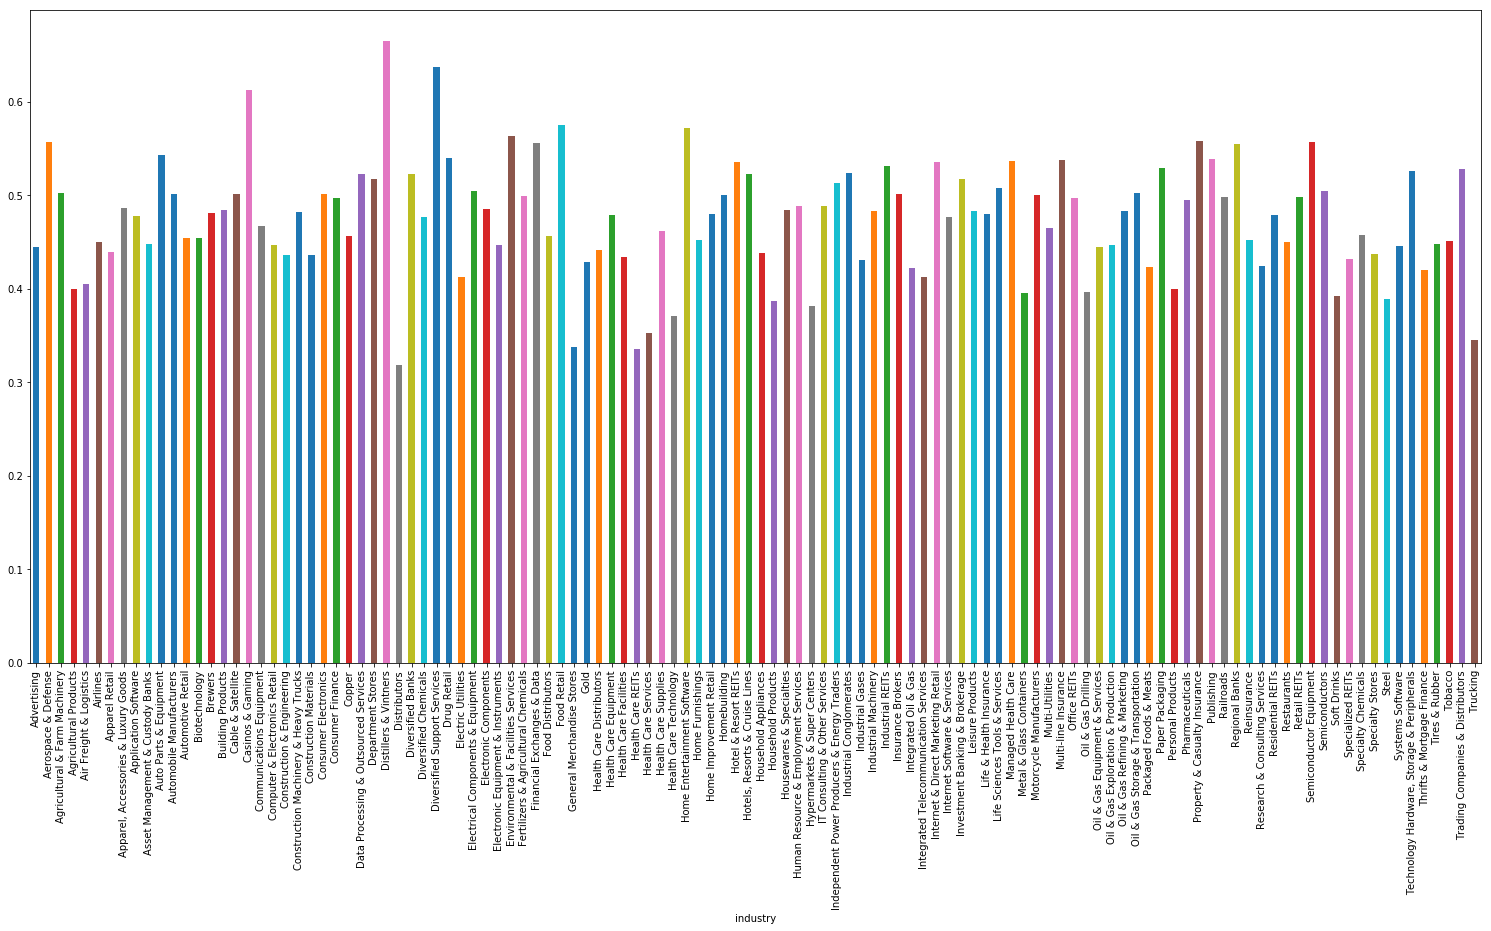

In [24]:
industrias.plot.bar() # visualización gráfica

Ordenamos las industras descendéntemente según el indice de Hurst, es decir de mas a menos tendenciales, incluyendo el número de valores que se incluye en cada industria dentro del SP500.

In [26]:
industrias=pd.DataFrame(industrias).sort_values('Hurst',ascending=False)
industrias['Num Valores']=muestra.groupby('industry')['Hurst'].count()
industrias

,Hurst,Num Valores
industry,,
Distillers & Vintners,0.664789,1
Diversified Support Services,0.636793,1
Casinos & Gaming,0.612739,2
Food Retail,0.575678,1
Home Entertainment Software,0.572328,3
Environmental & Facilities Services,0.563828,2
Property & Casualty Insurance,0.558602,8
Aerospace & Defense,0.557413,10
Semiconductor Equipment,0.557152,3


---

## Selección y guardado de los datos de los valores mas tendenciales

Finalmente seleccionamos aquellos valores que se muestran mas tendenciales o persistentes, es decir aquellos cuyo calculo del exponente de Hurst a resultado mayor que 0,55.

Estos valores los utilizaremos en el siguiente notebook del estudio, por lo que los guardamos en un archivo CSV para su posterior utilización.

In [28]:
seleccion=muestra[muestra.Hurst>0.55]
print('Número de valores seleccionados : {}'.format (seleccion.shape[0]))

Número de valores seleccionados : 73


In [29]:
seleccion.to_csv('seleccion muestra sp500.csv')

---